# Проверка гипотезы Тишби на примере классификатора

In [1]:
import numpy as np

In [2]:
import torch
import torchvision

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

Device: cuda
Devices count: 2


In [4]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "mutual_information/MNIST/"
models_path = experiments_path / "models/"
results_path = experiments_path / "resuts/"

### Глобальные настройки

In [5]:
# Автокодировщик для входа.
X_latent_dim = 4             # Размерность входа после сжатия.
X_autoencoder_n_epochs = 200 # Число эпох на обучение автокодировщика.
load_X_autoencoder = True    # Загрузить ли сохранённый автокодировщик.

# Автокодировщик для слоя.
L_latent_dim = 4              # Размерность слоёв после сжатия
L_autoencoder_n_epochs = 100  # Число эпох на обучение автокодировщика.

# Классификатор.
classifier_lr = 1e-5      # Скорость обучения классификатора.
classifier_n_epochs = 200 # Число эпох классификатора.
sigma = 1e-2

## Набор данных

In [6]:
from torchvision.datasets import MNIST

In [7]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [8]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [9]:
batch_size_train = 1024
batch_size_test  = 2048

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

### Визуализация

In [11]:
from misc.utils import *

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-21whbjcv because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


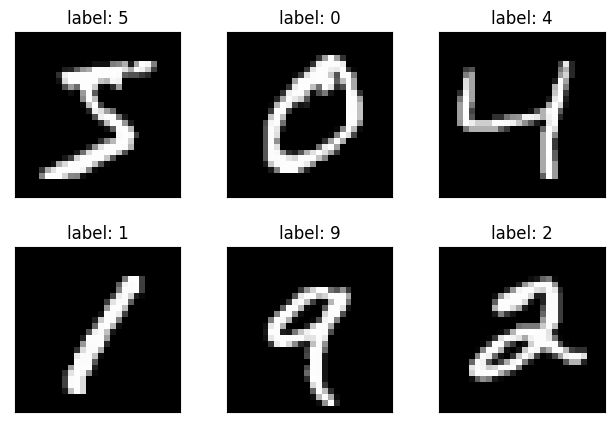

In [12]:
show_images(*split_lists([(train_dataset[index][0], f"label: {train_dataset[index][1]}") for index in range(6)]))

## Автокодировщик для входов

In [13]:
from mutinfo.torch.datasets import AutoencoderDataset

In [14]:
train_dataset_autoencoder = AutoencoderDataset(train_dataset)
test_dataset_autoencoder = AutoencoderDataset(test_dataset)

In [15]:
autoencoder_batch_size_train = 512
autoencoder_batch_size_test  = 1024

In [16]:
train_dataloader_autoencoder = torch.utils.data.DataLoader(train_dataset_autoencoder, batch_size=autoencoder_batch_size_train, shuffle=True)
test_dataloader_autoencoder  = torch.utils.data.DataLoader(test_dataset_autoencoder, batch_size=autoencoder_batch_size_test, shuffle=False)

In [17]:
from misc.autoencoder import *

In [18]:
import random
from IPython.display import clear_output

def autoencoder_callback(autoencoder, autoencoder_metrics=None):
    clear_output(True)
    
    was_in_training = autoencoder.training
    autoencoder.eval()
    
    # Отрисовка нескольких картинок.
    with torch.no_grad():
        samples = [sample[0] for sample in random.choices(test_dataset_autoencoder, k=3)]
        samples += [autoencoder(sample[None,:].to(device)).cpu().detach()[0] for sample in samples]
        show_images(samples)
        
    # Отрисовка графиков обучения.
    if not (autoencoder_metrics is None):
        plt.figure(figsize=(12,4))
        for index, (name, history) in enumerate(sorted(autoencoder_metrics.items())):
            plt.subplot(1, len(autoencoder_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();
        
    autoencoder.train(was_in_training)

In [19]:
X_autoencoder = Autoencoder(ConvEncoder(latent_dim=X_latent_dim), ConvDecoder(latent_dim=X_latent_dim)).to(device)

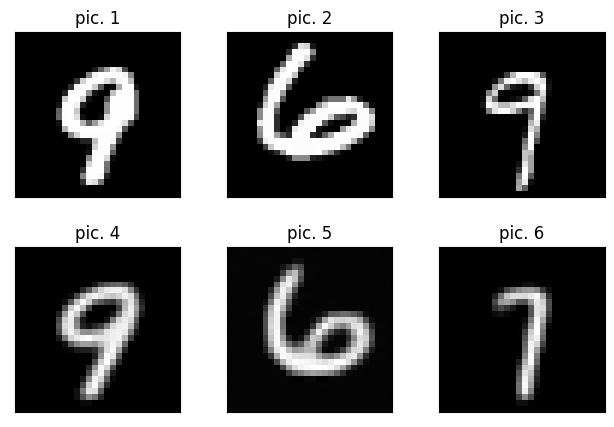

In [20]:
X_autoencoder_path = models_path / "autoencoders/"
encoder_path = X_autoencoder_path / f"X_encoder_{X_latent_dim}.pt"
decoder_path = X_autoencoder_path / f"X_decoder_{X_latent_dim}.pt"

if load_X_autoencoder:
    try:
        X_autoencoder.encoder.load_state_dict(torch.load(encoder_path))
        X_autoencoder.decoder.load_state_dict(torch.load(decoder_path))
        autoencoder_callback(X_autoencoder)
    except:
        print("Автокодировщик не найден или не может быть загружен")
        load_X_autoencoder = False
        
if not load_X_autoencoder:
    results = train_autoencoder(X_autoencoder, train_dataloader_autoencoder, test_dataloader_autoencoder, torch.nn.L1Loss(),
                                device, n_epochs=X_autoencoder_n_epochs, callback=autoencoder_callback)
    
    os.makedirs(X_autoencoder_path, exist_ok=True)
    torch.save(X_autoencoder.encoder.state_dict(), encoder_path)
    torch.save(X_autoencoder.decoder.state_dict(), decoder_path)

In [21]:
X_autoencoder.agn.enabled_on_inference = False
X_compressed = get_outputs(X_autoencoder.encoder, eval_dataloader, device).numpy()

## Классификатор

In [22]:
from misc.classifier import *
from tqdm import tqdm, trange
from sklearn.decomposition import PCA

In [23]:
classifier = Classifier(sigma=sigma).to(device)

In [24]:
import mutinfo.estimators.mutual_information as mi_estimators

In [25]:
# Параметры обучения.
classifier_loss = torch.nn.NLLLoss()
classifier_opt = torch.optim.Adam(classifier.parameters(), lr=classifier_lr)

In [26]:
# Настройки оценщика взаимной информации.

entropy_estimator_params = \
{
    'method': "KL",
    'functional_params': {'n_jobs': 16, "k_neighbours": 5}
}

compression = 'pca' # 'autoencoders', 'first_coords'

In [27]:
from collections import defaultdict

def train_classifier(classifier, classifier_loss, classifier_opt,
                     train_dataloader, test_dataloader, eval_dataloader,
                     X_compressed, entropy_estimator_params,
                     compression = 'pca', n_epochs: int=10):
    
    classifier_metrics = {
        "train_loss" : [],
        "test_loss" : [],
        "train_roc_auc" : [],
        "test_roc_auc" : []
    }
    
    # Автокодировщики.
    L_autoencoders = dict()
    
    # Взаимные информации.
    MI_X_L_history = defaultdict(list)
    MI_L_Y_history = defaultdict(list)
    
    # Метки.
    targets = eval_dataloader.dataset.targets.detach().cpu().numpy()
    
    for epoch in range(1, n_epochs + 1):       
        # Обучение.
        print(f"Эпоха №{epoch}")        
        for index, batch in tqdm(enumerate(train_dataloader)):
            x, y = batch
            batch_size = x.shape[0]
            
            classifier_opt.zero_grad()
            y_pred = classifier(x.to(device))
            _loss = classifier_loss(y_pred, y.to(device))
            _loss.backward()
            classifier_opt.step()
            
        # Метрики.
        print("Подсчёт метрик")
        train_loss, train_roc_auc = evaluate_classifier(classifier, train_dataloader, classifier_loss, device)
        classifier_metrics["train_loss"].append(train_loss)
        classifier_metrics["train_roc_auc"].append(train_roc_auc)
        
        test_loss, test_roc_auc = evaluate_classifier(classifier, test_dataloader, classifier_loss, device)
        classifier_metrics["test_loss"].append(test_loss)
        classifier_metrics["test_roc_auc"].append(test_roc_auc)
        
        # Слои.
        print("Получение значений слоёв")
        train_outputs = get_layers(classifier, train_dataloader, device)
        test_outputs = get_layers(classifier, test_dataloader, device)
        eval_outputs = get_layers(classifier, eval_dataloader, device)
        
        # Взаимная информация.
        for layer_name in eval_outputs.keys():
            this_L_latent_dim = min(L_latent_dim, torch.numel(eval_outputs[layer_name]) / eval_outputs[layer_name].shape[0])
            
            if compression == 'first_coords':
                L_compressed = eval_outputs[layer_name].numpy()
                L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                L_compressed = L_compressed[:,:this_L_latent_dim]
                
            elif compression == 'pca':
                L_compressed = eval_outputs[layer_name].numpy()
                L_compressed = np.reshape(L_compressed, (L_compressed.shape[0], -1))
                L_compressed = PCA(n_components=this_L_latent_dim).fit_transform(L_compressed)
                
            elif compression == 'autoencoders':
                print(f"Обучение автокодировщика для слоя {layer_name}")
                # Наборы данных.
                train_layer = train_outputs[layer_name]
                test_layer  = test_outputs[layer_name]
                eval_layer  = eval_outputs[layer_name]

                L_train_dataset = torch.utils.data.TensorDataset(train_layer, train_layer)
                L_test_dataset  = torch.utils.data.TensorDataset(test_layer, test_layer)
                L_eval_dataset  = torch.utils.data.TensorDataset(eval_layer, eval_layer)

                L_train_dataloader = torch.utils.data.DataLoader(L_train_dataset, batch_size=batch_size_train,
                                                                 shuffle=True)
                L_test_dataloader  = torch.utils.data.DataLoader(L_test_dataset, batch_size=batch_size_test,
                                                                 shuffle=False)
                L_eval_dataloader  = torch.utils.data.DataLoader(L_eval_dataset, batch_size=batch_size_test,
                                                                 shuffle=False)

                # Автокодировщик.
                if layer_name in L_autoencoders.keys():
                    L_autoencoder = L_autoencoders[layer_name]
                else:
                    print(f"Автокодировщик для слоя {layer_name} не найден.")
                    L_dim = train_layer.shape[1]
                    L_autoencoder = Autoencoder(DenseEncoder(input_dim=L_dim, latent_dim=this_L_latent_dim),
                                                DenseDecoder(latent_dim=this_L_latent_dim, output_dim=L_dim)).to(device)

                # Обучение.
                L_results = train_autoencoder(L_autoencoder, L_train_dataloader, L_test_dataloader, torch.nn.MSELoss(),
                                    device, n_epochs=L_autoencoder_n_epochs)
                L_autoencoders[layer_name] = L_autoencoder

                _baseline_PCA = PCA(n_components=this_L_latent_dim).fit(np.reshape(train_layer, (train_layer.shape[0], -1)))
                _baseline_layer = _baseline_PCA.inverse_transform(_baseline_PCA.transform(test_layer))
                baseline_loss = float(torch.nn.functional.mse_loss(test_layer, torch.tensor(_baseline_layer)))

                print(f"Train loss: {L_results['train_loss'][-1]:.2e}; test loss: {L_results['test_loss'][-1]:.2e}")
                print(f"Лучше базового метода: {baseline_loss:.2e} / {L_results['test_loss'][-1]:.2e} = {baseline_loss / L_results['test_loss'][-1]:.2f}")

                L_compressed = get_outputs(L_autoencoder.encoder, L_eval_dataloader, device).numpy()
                #L_compressed = PCA(n_components=L_latent_dim).fit_transform(np.reshape(layer, (layer.shape[0], -1)))
            
            print(f"Оценка взаимной информации для слоя {layer_name}")            
            # (X,L)
            print("I(X;L)")
            X_L_mi_estimator = mi_estimators.MutualInfoEstimator(entropy_estimator_params=entropy_estimator_params)
            X_L_mi_estimator.fit(X_compressed, L_compressed, verbose=0)
            MI_X_L_history[layer_name].append(X_L_mi_estimator.estimate(X_compressed, L_compressed, verbose=0))
            
            # (L,Y)
            print("I(L;Y)")
            L_Y_mi_estimator = mi_estimators.MutualInfoEstimator(Y_is_discrete=True,
                                                                 entropy_estimator_params=entropy_estimator_params)
            L_Y_mi_estimator.fit(L_compressed, targets, verbose=0)
            MI_L_Y_history[layer_name].append(L_Y_mi_estimator.estimate(L_compressed, targets, verbose=0))

        
        # Графики.
        clear_output(True)
        plt.figure(figsize=(18,4))
        for index, (name, history) in enumerate(sorted(classifier_metrics.items())):
            plt.subplot(1, len(classifier_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();
        
        plt.figure(figsize=(18,4))
        for index, layer_name in enumerate(MI_X_L_history.keys()):
            plt.subplot(1, len(MI_X_L_history.keys()), index + 1)
            plt.title(f"{layer_name}")
            plt.plot([item[0] for item in MI_X_L_history[layer_name]], [item[0] for item in MI_L_Y_history[layer_name]])
            plt.grid()

        plt.show();
        
    return {"metrics": classifier_metrics, "MI_X_L": MI_X_L_history, "MI_L_Y": MI_L_Y_history}

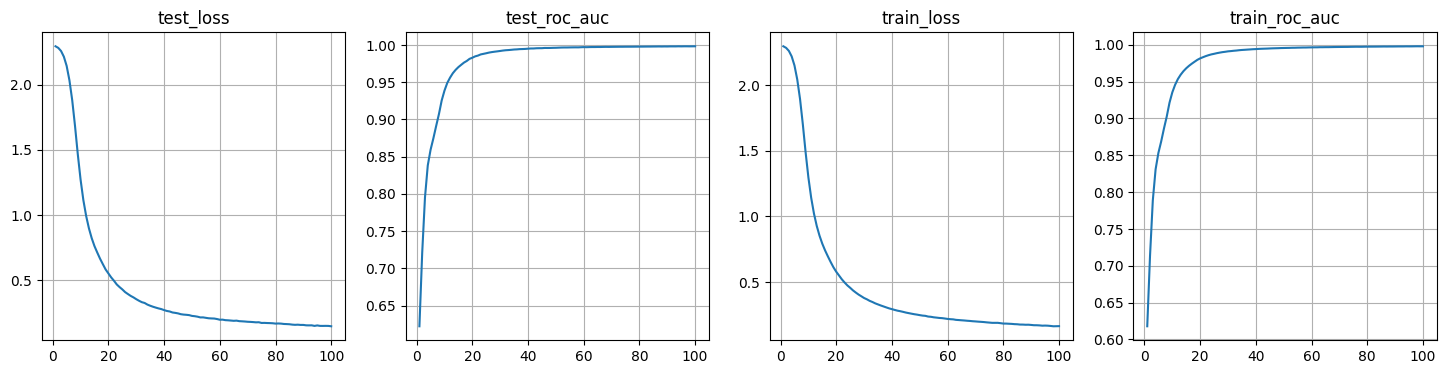

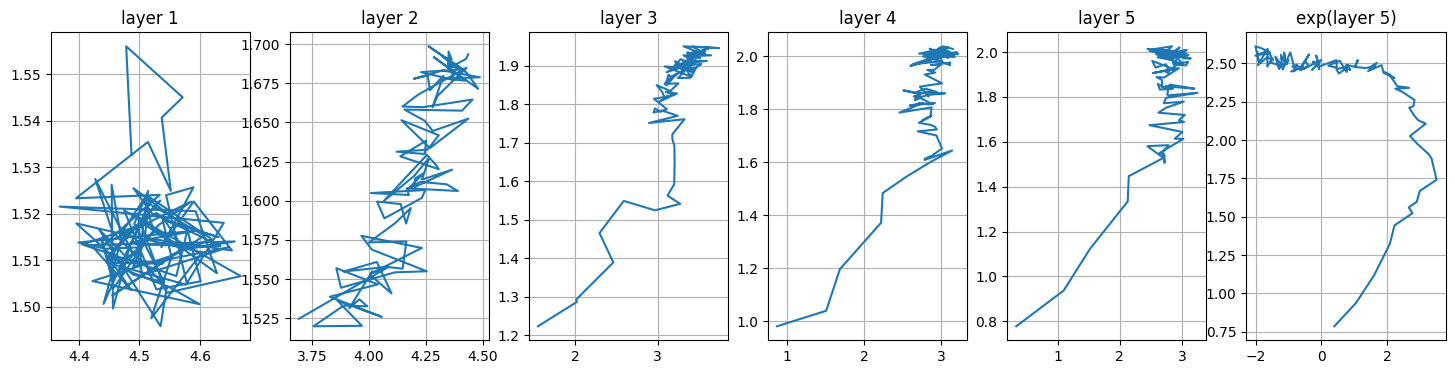

In [28]:
results = train_classifier(classifier, classifier_loss, classifier_opt,
                           train_dataloader, test_dataloader, eval_dataloader,
                           X_compressed, entropy_estimator_params,
                           compression, n_epochs=classifier_n_epochs)

In [29]:
from scipy.signal import savgol_filter

In [30]:
polyorder = 3
window_length = 20

In [31]:
results["filtered_MI_X_L"] = {layer_name: savgol_filter([item[0] for item in values], window_length, polyorder) for layer_name, values in results["MI_X_L"].items()}
results["filtered_MI_L_Y"] = {layer_name: savgol_filter([item[0] for item in values], window_length, polyorder) for layer_name, values in results["MI_L_Y"].items()}

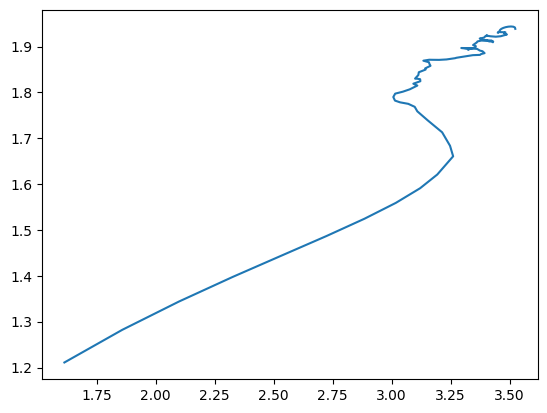

In [32]:
plt.plot(results["filtered_MI_X_L"]['layer 3'], results["filtered_MI_L_Y"]['layer 3'])

In [33]:
settings = {
    # Автокодировщик для входа.
    "X_latent_dim": X_latent_dim,
    "X_autoencoder_n_epochs": X_autoencoder_n_epochs,
    "load_X_autoencoder": load_X_autoencoder,
    
    # Автокодировщик для слоя.
    "L_latent_dim": L_latent_dim,
    "L_autoencoder_n_epochs": L_autoencoder_n_epochs,
    
    # Классификатор.
    "classifier_lr": classifier_lr,
    "classifier_n_epochs": classifier_n_epochs,
    "sigma": sigma,
    
    # Размер батчей.
    "batch_size_train": batch_size_train,
    "batch_size_test": batch_size_test,
    
    # Оценщик взаимной информации.
    "entropy_estimator_params": entropy_estimator_params,
    "compression": compression,
    
    # Сглаживание.
    "savgol_filter_polyorder": polyorder,
    "savgol_filter_window_length": window_length,
}

In [34]:
save_results(results, settings, results_path)